## Big Data Analytics 


## ADAPTIVE LINEAR NEURON (~Simple Perceptron) - Implementation in Spark 
The goal of this project is to implement a Simple ADALINE perceptron along with SGD in spark. Perceptron is the first neural network to exist. The functioning of perceptron is pretty similar to biological neurons. The ADALINE (Adaptive Linear Neuron) is a variant of perceptron and was introduced in 1959, shortly after Rosenblatt’s perceptron, by Bernard Widrow and Ted Hoff (one of the inventors of the microprocessor) at Stanford.

The main difference between the perceptron and the ADALINE is that the later works by minimizing the mean squared error of the predictions of a linear function. This means that the learning procedure is based on the outcome of a linear function rather than on the outcome of a threshold function as in the perceptron.

A simple perceptron model can be modeled as below

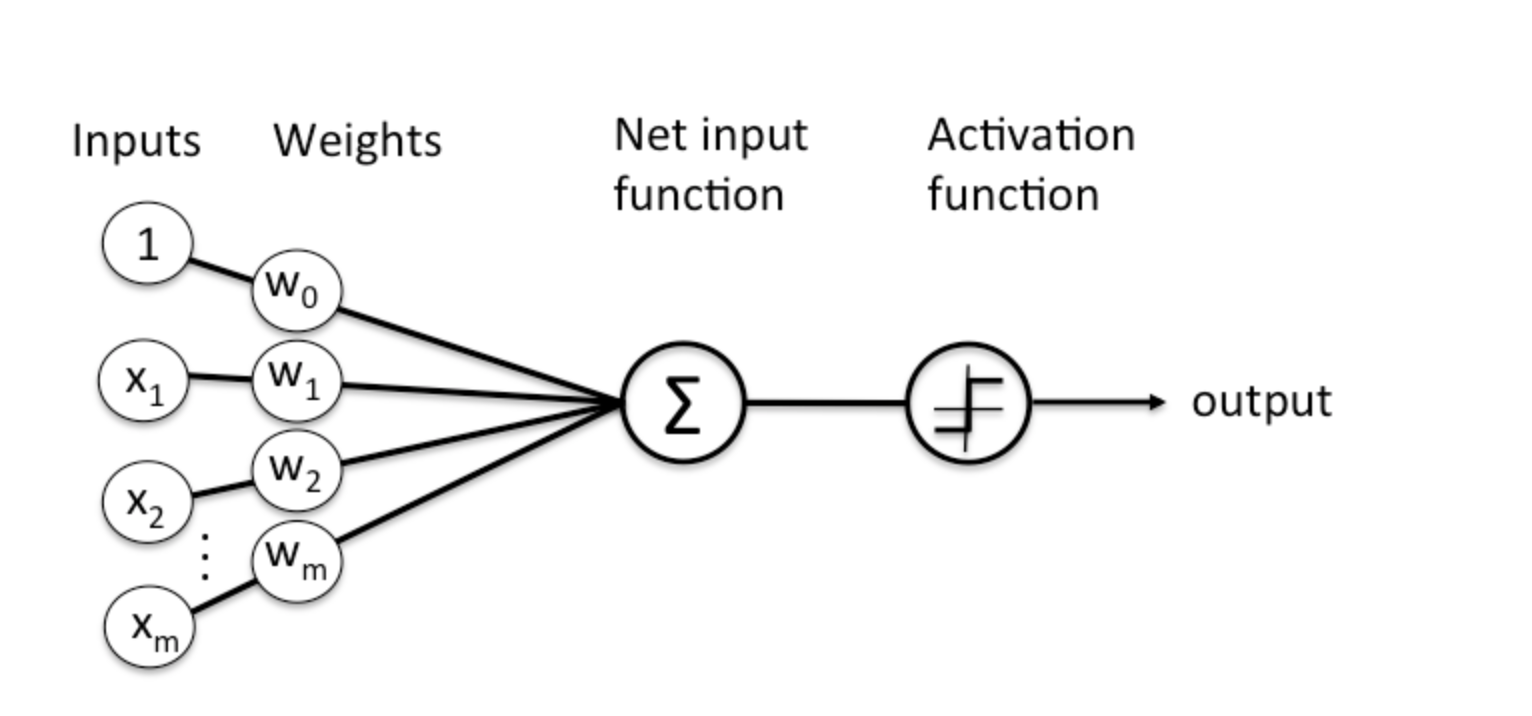

The intution of this project is to use the wikepedia document big data  and classify them as Australian court document(~positive) or wikipedia document(negative classes).

Using perceptron such binary classification problem can be modelled using linear equation below

${Z} = {W}_{0} + \sum \limits _{i=1}^{m} X_{i}{W}_{i}$  

This Z is known as Net input function value. 
This net input function value is passed on to activation function. 


**Learning Process**: The difference is the learning procedure to update the weight of the network. The perceptron updates the weights by computing the difference between the expected and predicted class values. In other words, the perceptron always compares +1 or -1 (predicted values) to +1 or -1 (expected values). An important consequence of this is that perceptron only learns when errors are made. In contrast, the ADALINE computes the difference between the expected class value  𝑦  (+1 or -1), and the continuous output value  𝑦̂   from the linear function, which can be any real number. This is crucial because it means the ADALINE can learn even when no classification mistake has been made. This is a consequence of the fact that predicted class values  𝑦̂ ′  do not influence the error computation. Since the ADALINE learns all the time and the perceptron only after errors, the ADALINE will find a solution faster than the perceptron for the same problem. 

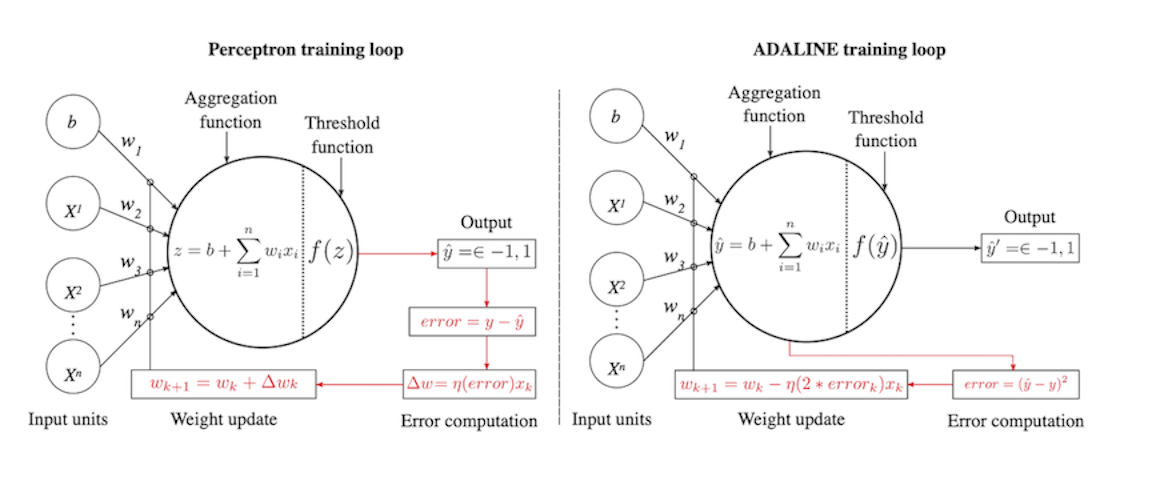


In this implementation the learning process of perceptron is carried out using mini batch 
stochastic gradient descent, and mean square error is used as cost function. 
The mathematical calculations can be written as 

_Weight update:_
    $${W} = {W} - \Delta{W} * LR$$ 
    
   $$\Delta{W} = \frac{ 2 * {X}.({X}.{W} - Y )}{SampleCount}$$
    
    
    

_Bias update:_
    $${W}_{0}  ={W}_{0} -  \Delta{W}_{0} * LR$$
    
 

 $$\Delta{W}_{0} = \frac{2 * \sum ({X}.{W} - {Y})}{SampleCount}$$
    
Where,<br>   **X** :  Input feature matrix <br>
         **W** : Intercept matrix (${W}_{1}...{W}_{m}$)<br>
       **W_0** : Bias for network<br>
        **LR** : Learning rate used for network<br>
**SampleCount**: Count of no of samples used for training the network

**Loss/Cost function:**<br> For calculating the loss/cost during network training **Mean Square Error** function 
is used. The cost function can be written as 

$${Cost} = \frac{\sum \limits _{i=1} ^{m}(\hat {Y}_{i} - {Y}_{i})^{2}}{SampleCount}$$

Where,<br> **Y** : Expected output matrix <br>
      $\hat {Y}$ : Calculated output matrix <br>
   **SampleCount**: Count of no of samples used for training the network
   

**Activation Function:** Perceptrons uses unit function, sometimes also known as Heaviside step function.Assuming g(Z) as activation function the activation function can be calculated using these calculations

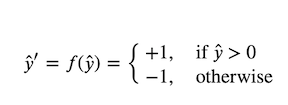
           

**import libraries** 

In [37]:
import sys
import re
import numpy as np
import random
from numpy import dot
from numpy.linalg import norm
import math
from pyspark.context import SparkContext
from pyspark.conf import SparkConf
import copy
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from PIL import Image

In [38]:
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

**Load the Data**

In [39]:
t0_start = datetime.datetime.now()
TrainData1= sc.textFile("SmallTrainingData.txt")
#TrainData= sc.textFile("SmallTrainingData.txt")
print(f"Time to load the training Data{datetime.datetime.now()-t0_start}" )
t0_temp = datetime.datetime.now()
#TestData= sc.textFile("TestingData.txt")
TestData1= sc.textFile("TestingData.txt")
print("Testing count")
print(TestData1.count())
TestData=  sc.parallelize(TestData1.take(300))
TrainData = sc.parallelize(TrainData1.take(500))
print(f"Time to load test Data {datetime.datetime.now() - t0_temp}")

numberOfDocs = TrainData.count()

print("Training RDD contains ", numberOfDocs ,"documents")

Time to load the training Data0:00:00.049051
Testing count
18724
Time to load test Data 0:00:06.582736
Training RDD contains  500 documents


**Define functions and initialize parameters**

In [40]:
stopWord_nltk = ['i','me','my', 'myself','we', 'our','ours','ourselves','you', "you're","you've","you'll",
 "you'd",'your','yours','yourself','yourselves','he','him', 'his','himself','she',"she's",
 'her','hers','herself','it',"it's",'its','itself','they','them','their','theirs','themselves',
 'what','which', 'who','whom', 'this','that',"that'll",'these','those','am','is','are',
 'was','were','be','been','being','have','has','had','having','do','does','did','doing',
 'a','an','the','and','but','if','or','because','as','until','while','of','at','by','for',
 'with','about','against','between','into','through','during','before','after','above',
 'below','to','from','up','down','in','out','on','off','over','under','again','further','then','once',
 'here','there','when','where','why','how','all','any','both','each','few','more','most','other',
 'some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will',
 'just','don',"don't",'should',"should've",'now','d','ll','m','o','re','ve','y','ain','aren',
 "aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",
 'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",
 'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't", 'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]

def filterStopWords(p):
    if p[0] not in stopWord_nltk:
        return p

In [41]:
dictionarySize = 500
#function for filtering out Australian court documents
def FilterRowAus(Row):
    if  Row[0] == 1:
        return Row
#function for filtering out Wikipedia documents    
def FilterRowWiki(Row):
    if  Row[0] == -1:
        return Row
def Documentype(variable):
    returnVal = -1
    if variable.strip().lower()[:2] == 'au':
        returnVal = 1
    else:
        returnVal = -1
    return returnVal

# **Steps Performed**

1. Generate dictionary from training data.
2. Remove all the stop words
3. Generate the Tf-IDF matrix for training data

In [42]:
t0_temp = datetime.datetime.now()
# Each entry in validLines will be a line from the text file
validTrainData = TrainData.filter(lambda x : 'id' in x and 'url=' in x)
keyAndText = validTrainData.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))
DocId_text = keyAndText.map(lambda x: (x[0] , Documentype(x[0]),x[1]))
regex = re.compile('[^a-zA-Z]')

# remove all non letter characters
keyAndListOfWords = keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))

# Now get the top 20,000 words... first change (docID, ["word1", "word2", "word3", ...])
# to ("word1", 1) ("word2", 1)...
allWords = keyAndListOfWords.map(lambda x: x[1]).flatMap(lambda x:x).map(lambda x: (x,1)).reduceByKey(lambda x, y: x+y)

#filter out the stop words from all words
allWords = allWords.filter(filterStopWords)

# Get the top 20,000 words in a local array in a sorted format based on frequency
# If you want to run it on your laptio, it may a longer time for top 20k words. 
topWords = allWords.top(dictionarySize, lambda x: x[1])
# We'll create a RDD that has a set of (word, dictNum) pairs
# start by creating an RDD that has the number 0 through 20000
# 20000 is the number of words that will be in our dictionary
topWordsK = sc.parallelize(range(dictionarySize))

# Now, we transform (0), (1), (2), ... to ("MostCommonWord", 1)
# ("NextMostCommon", 2), ...
# the number will be the spot in the dictionary used to tell us
# where the word is located
dictionary = topWordsK.mapPartitions(lambda s: map( lambda x: (topWords[x][0], x) , s))

In [43]:
def buildArray(listOfIndices ,dictionarySize):
    returnVal = np.zeros(dictionarySize)
    
    for index in listOfIndices:
        returnVal[index] = returnVal[index] + 1
    
    mysum = np.sum(returnVal)
    
    returnVal = np.divide(returnVal, mysum)
    
    return returnVal 


    
def build_zero_one_array (listOfIndices,dictionarySize):
    
    returnVal = np.zeros(dictionarySize)
    
    for index in listOfIndices:
        if returnVal[index] == 0: returnVal[index] = 1
    
    return returnVal

def stringVector(x):
    returnVal = str(x[0])
    for j in x[1]:
        returnVal += ',' + str(j)
    return returnVal

def cousinSim (x,y):
    normA = np.linalg.norm(x)
    normB = np.linalg.norm(y)
    return np.dot(x,y)/(normA*normB)

# Next, we get a RDD that has, for each (docID, ["word1", "word2", "word3", ...]),
# ("word1", docID), ("word2", docId), ...
allWordsWithDocID = keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))
print(allWordsWithDocID.take(2))

[('consideration', 'AU35'), ('of', 'AU35')]


In [44]:
#Now join and link them, to get a set of ("word1", (dictionaryPos, docID)) pairs
allDictionaryWords = dictionary.join(allWordsWithDocID)

# Now, we drop the actual word itself to get a set of (docID, dictionaryPos) pairs
justDocAndPos = allDictionaryWords.mapPartitions(lambda s: map( lambda x: (x[1][1],x[1][0]) , s) )
print(justDocAndPos.take(3))

# Now get a set of (docID, [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs ##this one takes time 
allDictionaryWordsInEachDoc = justDocAndPos.\
			mapPartitions(lambda s: map( lambda nameTuple: (nameTuple[0], [ nameTuple[1] ]) , s)).\
		   reduceByKey(lambda a, b: a + b).\
		   mapPartitions(lambda s: map( lambda x: (x[0], np.array(x[1])) , s))
#print(allDictionaryWordsInEachDoc.take(3))
# The following line this gets us a set of
# (docID,  [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
# and converts the dictionary positions to a bag-of-words numpy array...
allDocsAsNumpyArrays = allDictionaryWordsInEachDoc.mapPartitions(lambda s:  map(lambda x: (Documentype(x[0]),buildArray(x[1],dictionarySize)),s))
#allDocsAsNumpyArrays.cache()
#print("allDocsAsNumpyArrays cached")
#print(allDocsAsNumpyArrays.take(3))    
# Now, create a version of allDocsAsNumpyArrays where, in the array,
# every entry is either zero or one.
# A zero means that the word does not occur,
# and a one means that it does.
def RetZeroOrOne(X):
    return [ 1 if i!=0 else 0 for i in X ]
    
asign = lambda t: 1.0 if t !=0.0 else 0.0

'''RddDocAsNumpyArrayValues = allDocsAsNumpyArrays.\
                        mapPartitions(lambda s:  map(lambda x: (x[0] ,x[1][0]),s))'''
                        #map(lambda x: (x[0] ,x[1][0]))

zeroOrOne = allDocsAsNumpyArrays.mapValues(RetZeroOrOne)
#print(zeroOrOne.take(2))

[('AU35', 3), ('AU35', 3), ('AU35', 3)]


In [45]:
# Now, add up all of those arrays into a single array, where the
# i^th entry tells us how many
# individual documents the i^th word in the dictionary appeared in
dfArray = zeroOrOne.reduce(lambda x1, x2: ("", np.add(x1[1], x2[1])))[1]
# Create an array of dictionarySize entries, each entry with the value numberOfDocs (number of docs)
multiplier = np.full(dictionarySize, numberOfDocs)
# Get the version of dfArray where the i^th entry is the inverse-document frequency for the
# i^th word in the corpus
idfArray = np.log(np.divide(np.full(dictionarySize, numberOfDocs), dfArray))

print("Calculating allDocsAsNumpyArraysTFidf")
# Finally, convert all of the tf vectors in allDocsAsNumpyArrays to tf * idf vectors
TrainingTFidf = allDocsAsNumpyArrays.\
        mapPartitions(lambda s:  map(lambda x: (x[0], np.multiply(x[1], idfArray)),s))
#print(TrainingTFidf.take(2))
print(f"Time to Prepare the training Data in required format {datetime.datetime.now() - t0_temp}")
print("---------------------------------------------------------------")
t0_temp = datetime.datetime.now()

Calculating allDocsAsNumpyArraysTFidf
Time to Prepare the training Data in required format 0:00:05.557392
---------------------------------------------------------------


**Training dictionary words overview**

In [46]:
def makeImage(text ,title):
    cloud_mask = np.array(Image.open("cloud.png"))

    wc = WordCloud(background_color="white", mask=cloud_mask)
    # generate word cloud
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(10,10))
    plt.title(title)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

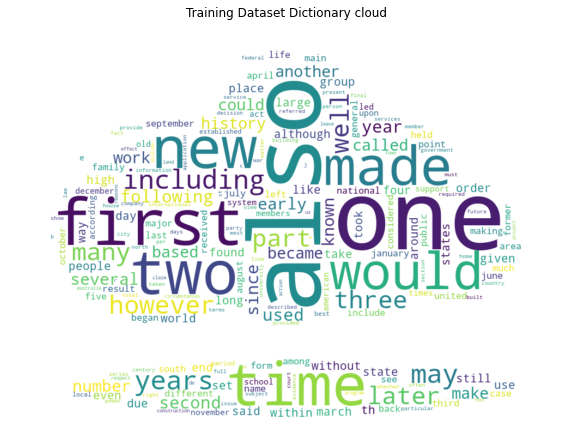

In [47]:
#FreqCountRDD=sc.parallelize(list(dfArray))
Words= dictionary.take(250)
count = dfArray[ :250]
Dict_words = {}

for x in range(len(Words)) :
    Dict_words[Words[x][0]] = count[x]   



makeImage(Dict_words , "Training Dataset Dictionary cloud")



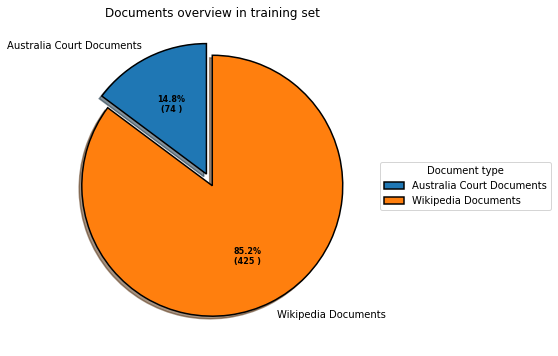

In [48]:
#get the labels 
AusCourtDoc = TrainingTFidf.filter(FilterRowAus).count()
Wikipedia =  TrainingTFidf.filter(FilterRowWiki).count()

Data=[AusCourtDoc,Wikipedia]
Label_Values = ["Australia Court Documents","Wikipedia Documents"]
explode = (0.1, 0.0)

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

# Wedge properties
wp = { 'linewidth' : 1.5, 'edgecolor' : "black" }
fig, ax = plt.subplots(figsize =(10, 6))
wedges, texts, autotexts = ax.pie(Data, 
                                  autopct = lambda pct: func(pct, Data),
                                  explode = explode, 
                                  labels = Label_Values,
                                  shadow = True,
                                  #colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp#,
                                 )
  
# Adding legend
ax.legend(wedges, Label_Values,
          title ="Document type",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
  
plt.setp(autotexts, size = 8, weight ="bold")

ax.set_title("Documents overview in training set")
plt.show()

# **Steps Performed**

1. Generate Tf-idf matrix for testing data using the dictionary and idf of training data

In [49]:
t0_temp = datetime.datetime.now() 
#Tfidf for test data
TestDataValid = TestData.filter(lambda x : 'id' in x and 'url=' in x)
# Now, we transform it into a set of (docID, text) pairs
keyAndText_1 =  TestDataValid.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))
# remove all non letter characters
regex = re.compile('[^a-zA-Z]')

# remove all non letter characters
keyAndListOfWords_1 = keyAndText_1.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))

# Next, we get a RDD that has, for each (docID, ["word1", "word2", "word3", ...]),
# ("word1", docID), ("word2", docId), ...
allWordsWithDocID_1 = keyAndListOfWords_1.flatMap(lambda x: ((j, x[0]) for j in x[1]))

#Now join and link them, to get a set of ("word1", (dictionaryPos, docID)) pairs
allDictionaryWords_1 = dictionary.join(allWordsWithDocID_1)

# Now, we drop the actual word itself to get a set of (docID, dictionaryPos) pairs
#justDocAndPos_1 = allDictionaryWords_1.map(lambda x: (x[1][1],x[1][0]))
justDocAndPos_1 = allDictionaryWords_1.mapPartitions(lambda s: map( lambda x: (x[1][1],x[1][0]) , s) )

print("(docID, dictionaryPos) pairs created ")

# Now get a set of (docID, [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
#justDocAndPos.map(lambda nameTuple: (nameTuple[0], [ nameTuple[1] ])).reduceByKey(lambda a, b: a + b)
allDictionaryWordsInEachDoc_1 = justDocAndPos_1.map(lambda nameTuple: (nameTuple[0], [ nameTuple[1] ])).\
            reduceByKey(lambda a, b: a + b).map(lambda x: (x[0], np.array(x[1])))#groupByKey()
# The following line this gets us a set of
# (docID,  [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
# and converts the dictionary positions to a bag-of-words numpy array...
allDocsAsNumpyArrays_1 = allDictionaryWordsInEachDoc_1.mapPartitions(lambda s:  map(lambda x: (Documentype(x[0]),buildArray(x[1],dictionarySize),x[0]),s))
print("(docID,  [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs created ")
allDocsAsNumpyArraysTFidf_1 = allDocsAsNumpyArrays_1.mapPartitions(lambda s:  map(lambda x: (x[0], np.multiply(x[1], idfArray) , x[2]),s))

#allDocsAsNumpyArraysTFidf.unpersist()
#print("allDocsAsNumpyArraysTFidf uncached")
#print(allDocsAsNumpyArraysTFidf_1.take(3))
#allDocsAsNumpyArraysTFidf_1.cache()
print("allDocsAsNumpyArraysTFidf_1 cached")

print(f"Time to Prepare the Test Data in required format {datetime.datetime.now() - t0_temp}")

(docID, dictionaryPos) pairs created 
(docID,  [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs created 
allDocsAsNumpyArraysTFidf_1 cached
Time to Prepare the Test Data in required format 0:00:00.071937


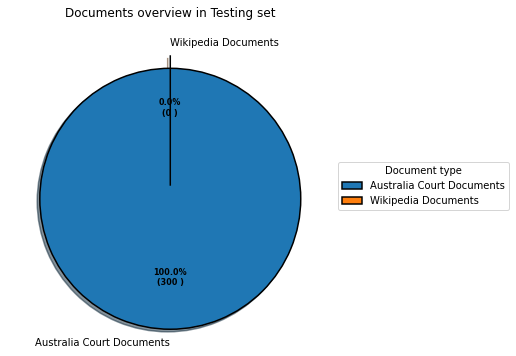

In [57]:
#get the labels 
AusCourtDoc = allDocsAsNumpyArraysTFidf_1.filter(FilterRowAus).count()
Wikipedia =  allDocsAsNumpyArraysTFidf_1.filter(FilterRowWiki).count()

Data=[AusCourtDoc,Wikipedia]
Label_Values = ["Australia Court Documents","Wikipedia Documents"]
explode = (0.1, 0.0)

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

# Wedge properties
wp = { 'linewidth' : 1.5, 'edgecolor' : "black" }
fig, ax = plt.subplots(figsize =(10, 6))
wedges, texts, autotexts = ax.pie(Data, 
                                  autopct = lambda pct: func(pct, Data),
                                  explode = explode, 
                                  labels = Label_Values,
                                  shadow = True,
                                  #colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp#,
                                 )
  
# Adding legend
ax.legend(wedges, Label_Values,
          title ="Document type",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
  
plt.setp(autotexts, size = 8, weight ="bold")

ax.set_title("Documents overview in Testing set")
plt.show()

**Perceptron implementation phases**
1. Initialize weights and intercepts
2. Train the perceptron model 
3. Plot the learning curve

In [50]:
#applicable on individual items --
def activation_function(X):
    returnVal =0
    if X > 0.0:
        returnVal = 1
    else:
        returnVal = -1
    return returnVal


In [51]:
#set fraction for sampling
fractions = {1: 0.85, -1: 0.02}
randomstate =1
#generate a random number 
randomGen = np.random.RandomState(55)
Weights = randomGen.normal(loc=0.0, scale=1, size=dictionarySize)
Weights =[round(a, 4) for a in Weights]
intercept =randomGen.normal(loc=0.0, scale=1, size=1)
intercept =[round(a, 4) for a in intercept]

In [52]:
CostMatrix =[]
epochMatrix=[]
Learning_Rate = 0.0009
#set the epoch number
epochs = 1000

In [53]:
for i in range(0,epochs):
    #fetch samples for 
    samples= TrainingTFidf.sampleByKey(True, fractions, 2)
    #fetch the sample size 
    Sample_size = samples.count()
    #Calculate the 
    #Map layers and their respective outputs
    #map 1 : Y , X , X.W + B , ((X.W + B) - Y)
    #map 2 : Y , X.W + B   , X.((X.W + B) -Y)
    #map 3 : ((X.W + B) -Y)^2 , (X.W + B) - Y ,  X.T.((X.W + B) -Y)
    Predictions = samples.map(lambda x : (x[0] ,x[1] ,np.dot(x[1] ,Weights) + intercept , ((np.dot(x[1] ,Weights) + intercept) -x[0] ))).\
        map(lambda x: (x[0] ,  x[2] , np.multiply(x[1]  , x[3] ) )).\
        map(lambda x:  ( np.square( x[1] - x[0] ) ,  x[1] - x[0] ,x[2] ) ).\
        reduce(lambda x, y  : (x[0] +y[0], x[1]+y[1] ,x[2]+y[2] ))
    
    w_grad = 2/Sample_size * Predictions[2]
            
    b_grad = 2/Sample_size * Predictions[1]
    
    cost= 1/Sample_size * Predictions[0]
    #cost= 1/2 * Predictions[0]
    
    #append epocj
    epochMatrix.append(i)
    #append value of Cost
    CostMatrix.append(cost)
    
    #check if cost is 0
    if (CostMatrix[-1] == 0.0):
        break
        
    #update the weights
    Weights = Weights - np.multiply(Learning_Rate , w_grad) 
    intercept = intercept - np.multiply(Learning_Rate , b_grad)
   
    print("Epoch :" + str(epochMatrix[-1]) + " Cost :" + str(CostMatrix[-1]))
                
    
                
    
    #np.dot(X, self.Weights[1:]) + self.Weights[0]

Epoch :0 Cost :[3.5534187]
Epoch :1 Cost :[3.54218935]
Epoch :2 Cost :[3.53100092]
Epoch :3 Cost :[3.51985325]
Epoch :4 Cost :[3.5087462]
Epoch :5 Cost :[3.49767961]
Epoch :6 Cost :[3.48665336]
Epoch :7 Cost :[3.47566727]
Epoch :8 Cost :[3.46472122]
Epoch :9 Cost :[3.45381505]
Epoch :10 Cost :[3.44294862]
Epoch :11 Cost :[3.43212178]
Epoch :12 Cost :[3.42133438]
Epoch :13 Cost :[3.4105863]
Epoch :14 Cost :[3.39987737]
Epoch :15 Cost :[3.38920747]
Epoch :16 Cost :[3.37857644]
Epoch :17 Cost :[3.36798414]
Epoch :18 Cost :[3.35743044]
Epoch :19 Cost :[3.34691519]
Epoch :20 Cost :[3.33643825]
Epoch :21 Cost :[3.32599949]
Epoch :22 Cost :[3.31559876]
Epoch :23 Cost :[3.30523592]
Epoch :24 Cost :[3.29491085]
Epoch :25 Cost :[3.28462339]
Epoch :26 Cost :[3.27437341]
Epoch :27 Cost :[3.26416078]
Epoch :28 Cost :[3.25398536]
Epoch :29 Cost :[3.24384701]
Epoch :30 Cost :[3.2337456]
Epoch :31 Cost :[3.223681]
Epoch :32 Cost :[3.21365306]
Epoch :33 Cost :[3.20366166]
Epoch :34 Cost :[3.19370667]
E

Epoch :278 Cost :[1.58847639]
Epoch :279 Cost :[1.58440436]
Epoch :280 Cost :[1.58034716]
Epoch :281 Cost :[1.57630473]
Epoch :282 Cost :[1.57227701]
Epoch :283 Cost :[1.56826395]
Epoch :284 Cost :[1.5642655]
Epoch :285 Cost :[1.56028161]
Epoch :286 Cost :[1.55631222]
Epoch :287 Cost :[1.55235728]
Epoch :288 Cost :[1.54841673]
Epoch :289 Cost :[1.54449053]
Epoch :290 Cost :[1.54057862]
Epoch :291 Cost :[1.53668094]
Epoch :292 Cost :[1.53279746]
Epoch :293 Cost :[1.52892811]
Epoch :294 Cost :[1.52507285]
Epoch :295 Cost :[1.52123162]
Epoch :296 Cost :[1.51740437]
Epoch :297 Cost :[1.51359105]
Epoch :298 Cost :[1.50979161]
Epoch :299 Cost :[1.506006]
Epoch :300 Cost :[1.50223417]
Epoch :301 Cost :[1.49847607]
Epoch :302 Cost :[1.49473165]
Epoch :303 Cost :[1.49100085]
Epoch :304 Cost :[1.48728364]
Epoch :305 Cost :[1.48357995]
Epoch :306 Cost :[1.47988975]
Epoch :307 Cost :[1.47621297]
Epoch :308 Cost :[1.47254958]
Epoch :309 Cost :[1.46889952]
Epoch :310 Cost :[1.46526275]
Epoch :311 Co

Epoch :552 Cost :[0.88151953]
Epoch :553 Cost :[0.88001881]
Epoch :554 Cost :[0.87852354]
Epoch :555 Cost :[0.8770337]
Epoch :556 Cost :[0.87554927]
Epoch :557 Cost :[0.87407023]
Epoch :558 Cost :[0.87259656]
Epoch :559 Cost :[0.87112824]
Epoch :560 Cost :[0.86966526]
Epoch :561 Cost :[0.86820758]
Epoch :562 Cost :[0.8667552]
Epoch :563 Cost :[0.86530809]
Epoch :564 Cost :[0.86386623]
Epoch :565 Cost :[0.86242961]
Epoch :566 Cost :[0.8609982]
Epoch :567 Cost :[0.85957199]
Epoch :568 Cost :[0.85815096]
Epoch :569 Cost :[0.85673509]
Epoch :570 Cost :[0.85532435]
Epoch :571 Cost :[0.85391874]
Epoch :572 Cost :[0.85251823]
Epoch :573 Cost :[0.8511228]
Epoch :574 Cost :[0.84973244]
Epoch :575 Cost :[0.84834713]
Epoch :576 Cost :[0.84696684]
Epoch :577 Cost :[0.84559157]
Epoch :578 Cost :[0.84422129]
Epoch :579 Cost :[0.84285598]
Epoch :580 Cost :[0.84149562]
Epoch :581 Cost :[0.84014021]
Epoch :582 Cost :[0.83878971]
Epoch :583 Cost :[0.83744412]
Epoch :584 Cost :[0.83610341]
Epoch :585 Cos

Epoch :827 Cost :[0.62004272]
Epoch :828 Cost :[0.61948928]
Epoch :829 Cost :[0.61893783]
Epoch :830 Cost :[0.61838837]
Epoch :831 Cost :[0.61784089]
Epoch :832 Cost :[0.61729538]
Epoch :833 Cost :[0.61675185]
Epoch :834 Cost :[0.61621027]
Epoch :835 Cost :[0.61567064]
Epoch :836 Cost :[0.61513297]
Epoch :837 Cost :[0.61459723]
Epoch :838 Cost :[0.61406342]
Epoch :839 Cost :[0.61353153]
Epoch :840 Cost :[0.61300156]
Epoch :841 Cost :[0.61247351]
Epoch :842 Cost :[0.61194735]
Epoch :843 Cost :[0.6114231]
Epoch :844 Cost :[0.61090073]
Epoch :845 Cost :[0.61038025]
Epoch :846 Cost :[0.60986164]
Epoch :847 Cost :[0.6093449]
Epoch :848 Cost :[0.60883002]
Epoch :849 Cost :[0.608317]
Epoch :850 Cost :[0.60780583]
Epoch :851 Cost :[0.6072965]
Epoch :852 Cost :[0.606789]
Epoch :853 Cost :[0.60628333]
Epoch :854 Cost :[0.60577949]
Epoch :855 Cost :[0.60527746]
Epoch :856 Cost :[0.60477723]
Epoch :857 Cost :[0.60427881]
Epoch :858 Cost :[0.60378219]
Epoch :859 Cost :[0.60328735]
Epoch :860 Cost :

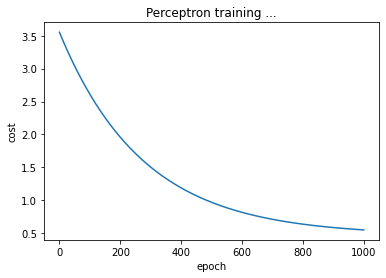

In [54]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Perceptron training ...")
plt.plot(epochMatrix,CostMatrix)
plt.show()

In [55]:
#perform Prediction
print("No of Test documents")
print(allDocsAsNumpyArraysTFidf_1.count())

No of Test documents
300


In [56]:
#calculate Prediction 
Test_Prediction = allDocsAsNumpyArraysTFidf_1.map(lambda x: ( x[0] , activation_function( np.dot(x[1] ,Weights) + intercept)))
Dataframe = spark.createDataFrame(Test_Prediction, ["target" ,"prediction"])
print(Dataframe.count())

TP = Dataframe[(Dataframe.prediction == 1) & (Dataframe.target == 1)].count()
FP = Dataframe[(Dataframe.prediction == 1) & (Dataframe.target == -1)].count()
TN = Dataframe[(Dataframe.prediction == -1) & (Dataframe.target == -1)].count()
FN = Dataframe[(Dataframe.prediction == -1) & (Dataframe.target == 1)].count()

print("True Positive : " ,TP  )
print("False Positive : " ,FP )
print("True Negative : " ,TN )
print("False Negative : " , FN )

precision = np.float(TP) / np.float((TP + FP + 0.000001))
print(f"Precision is :{precision}")
recall = TP / (TP + FN+ 0.000001 )
print(f"Recall is :{recall}")

f1_score = 2 * precision * recall / (precision + recall+ 0.000001 )
print(f"F1 score is :{f1_score}")

300
True Positive :  265
False Positive :  0
True Negative :  0
False Negative :  35
Precision is :0.9999999962264151
Recall is :0.883333330388889
F1 score is :0.9380525959435647


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


References:
https://com-cog-book.github.io//com-cog-book/features/adaline.html